In [1]:
import numpy as np
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
alpha = 0.05
p = 2

In [3]:
csi = np.array([1, 0, 1])
etta = np.array([0, 1, 1])
omega = np.array([1, 5, 2])
data_table = pd.DataFrame({r'ξ': csi, r'η': etta, r'ω': omega})
data_table

,ξ,η,ω
0,1,0,1
1,0,1,5
2,1,1,2


In [4]:
Y = omega
n = np.size(Y)

X = np.stack((csi, etta), axis = 1)

# Уравнение линейной регрессии

In [6]:
F = X.T @ X
F_inv = np.linalg.inv(F)

b = F_inv @ X.T @ Y

model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X, Y)

print(f"Уравнение: ω = {np.round(b[0], 2)}*ξ + {np.round(b[1], 2)}*η")

# Create a pandas DataFrame to display the coefficients
# coefficients_df = pd.DataFrame({'My Coefficients': np.round(b, 2), 'Sklearn coefficients': np.round(model.coef_, 2)})
# coefficients_df

Уравнение: ω = -0.33*ξ + 3.67*η


In [53]:
def line_equation(x1, x2):
    global b
    return b[0] * x1 + b[1] * x2


# Create the figure and the 3D axes
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')

# # Plot the two points
# ax.scatter(X[:, 0], X[:, 1], y, c='r', marker='o')

# # Plot the line connecting the two points
# x1_coord = np.linspace(-10, 10, 100)
# x2_coord = np.linspace(-10, 10, 100)
# ax.plot(x1_coord, x2_coord, line_equation(x1, x2), c='g')

# # Set the axis labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# # Show the plot
# plt.show()

#  Уравнение Ridge регрессии

In [67]:
lambds = np.linspace(0, 10, 1000)

In [68]:
kf = KFold(n_splits=n, shuffle=False)
def CVSS_function_ridge(lambd):
    def lagrange_function(x):
        e = Y_train - X_train @ x
        L = (e.T @ e) + lambd * (np.sum(x ** 2))
        return L
        
    RSS_CV = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        F = X_train.T @ X_train
        F_inv = np.linalg.inv(F)
        b = F_inv @ X_train.T @ Y_train

        # Минимизируем функцию Лагранжа
        x_0 = b
        result = minimize(lagrange_function, x_0, method='Nelder-Mead')
        beta_wave = result.x

        RSS_CV.append(np.sum((beta_wave @ X_val[0] - Y_val) ** 2))
        
    RSS_CV = np.array(RSS_CV)
    CVSS = np.sum(RSS_CV)
    return CVSS

lambda_0 = 0
result_ridge = minimize(CVSS_function_ridge, lambda_0, method='Nelder-Mead').x
CVSSs = np.array([CVSS_function_ridge(x_i) for x_i in lambds])

lambda_min = 1.51


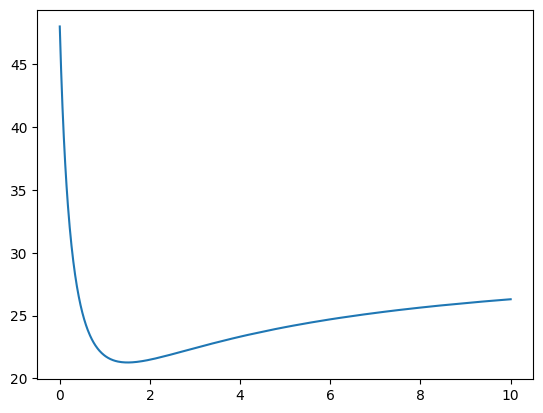

In [69]:
plt.plot(lambds, CVSSs)
print(f'lambda_min = {np.round(result_ridge[0], 2)}')
# print(f'CVSS_min = {np.round(CVSS_function_ridge(result_ridge), 2)}')

In [70]:
def lagrange_function_beta(x):
        e = Y - X @ x
        L = (e.T @ e) + result_ridge[0] * (np.sum(x ** 2))
        return L

x_0 = b
result_beta = minimize(lagrange_function_beta, x_0, method='Nelder-Mead')
result_beta = result_beta.x

print(f"Уравнение: ω = {np.round(result_beta[0], 2)}ξ + {np.round(result_beta[1], 2)}η")


# model_ridge = linear_model.Ridge(fit_intercept=False)
# model_ridge.fit(X, Y)


# # Create a pandas DataFrame to display the coefficients
# coefficients_df = pd.DataFrame({'My Coefficients': np.round(result_beta, 2), 'Sklearn coefficients': np.round(model_ridge.coef_, 2)})
# coefficients_df

Уравнение: ω = 0.31ξ + 1.9η


# Уравнение Lasso регрессии

In [71]:
kf = KFold(n_splits=n, shuffle=False)
def CVSS_function_lasso(lambd):
    def lagrange_function(x):
        e = Y_train - X_train @ x
        L = (e.T @ e) + lambd * (np.sum(np.abs(x)))
        return L
        
    RSS_CV = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        F = X_train.T @ X_train
        F_inv = np.linalg.inv(F)
        b = F_inv @ X_train.T @ Y_train

        # Минимизируем функцию Лагранжа
        x_0 = b
        result = minimize(lagrange_function, x_0, method='Nelder-Mead')
        beta_wave = result.x

        RSS_CV.append(np.sum((beta_wave @ X_val[0] - Y_val) ** 2))
        
    RSS_CV = np.array(RSS_CV)
    CVSS = np.sum(RSS_CV)
    return CVSS

lambda_0 = 0
result_lasso = minimize(CVSS_function_lasso, lambda_0, method='Nelder-Mead').x
CVSSs = np.array([CVSS_function_lasso(x_i) for x_i in lambds])

lambda_min = 6.0


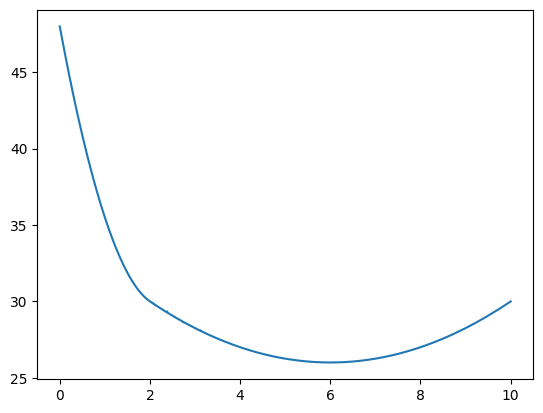

In [72]:
plt.plot(lambds, CVSSs)
print(f'lambda_min = {np.round(result_lasso[0], 2)}')
# print(f'CVSS_min = {np.round(CVSS_function_lasso(result_lasso), 2)}')

In [73]:
def lagrange_function_beta(x):
        e = Y - X @ x
        L = (e.T @ e) + result_lasso[0] * (np.sum(np.abs(x)))
        return L

x_0 = b
result_beta = minimize(lagrange_function_beta, x_0, method='Nelder-Mead')
result_beta = result_beta.x

print(f"Уравнение: ω = {np.round(result_beta[0], 2)}ξ + {np.round(result_beta[1], 2)}η")


# model_lasso = linear_model.Lasso(fit_intercept=False)
# model_lasso.fit(X, Y)


# # Create a pandas DataFrame to display the coefficients
# coefficients_df = pd.DataFrame({'My Coefficients': np.round(result_beta, 2), 'Sklearn coefficients': np.round(model_lasso.coef_, 2)})
# coefficients_df

Уравнение: ω = -0.0ξ + 2.0η
